In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import itertools
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image, ImageOps

import configs
from utils import utils
from utils import laion_utils as laionu
from utils import wordnet_utils as wnu
from utils.calc_utils import calc_recall_per_y, calc_equi_acc
from core.queries import QueryType, query_name_def, query_name, query_lammas
from core.retrieve_image import download_image

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

## LAIONet filters

In [4]:
q_type = QueryType.NAME_DEF
q_key = 'wnid'
# text_encoder_ver = configs.CLIPConfig.DEFAULT_VERSION
text_encoder_ver = 'all-mpnet-base-v2'

query_col = q_type + '_' + q_key

text_query_sim_col = f'text_to_{query_col}_similarity_{text_encoder_ver}'

print(text_query_sim_col)

text_to_name_def_wnid_similarity_all-mpnet-base-v2


## Path

### LAIONet

In [5]:
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = configs.NamingConfig.append_skimmed(
    configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)
)

laionet_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)

# Labels
laionet_labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
laionet_labels_file_name = f'wnid2laionindices({laionet_prefix}).pkl'

# Predictions path
laionet_predictions_path = os.path.join(laion_path, 'processed', 'ilsvrc_predictions')

### ILSVRC val

In [6]:
ilsvrc_path = 'ilsvrc2012'

ilsvrc_val_prefix = 'ILSVRC2012_val'

ilsvrc_val_file_name = ilsvrc_val_prefix + '.parquet'

# Labels
ilsvrc_val_labels_file_path = os.path.join(ilsvrc_path, 'processed', 'labels', 'imagename2wnid.pkl')

# Images
ilsvrc_val_img_path = os.path.join(ilsvrc_path, 'ILSVRC2012_img_val')

## Model

In [7]:
model_name = 'vit-base-patch16-224'

## Other

In [8]:
top_k_col = lambda k, mdl: f'top_{k}_is_correct_{mdl}'
rec_text_is_in_col = f'wnid_is_in_recognized_text'

# Load

## LAIONet

In [9]:
df = pd.read_parquet(
    os.path.join(laion_path, laionet_file_name)
)

print(df.shape)

df.head(3)

(41265, 74)


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,...,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k,wnid_is_in_recognized_text
2908497206,3.067475e+12,https://c8.alamy.com/comp/GCAKFC/dyrholaey-pro...,"Dyrholaey promontory, formerly an island of vo...",1300.0,957.0,?,UNLIKELY,0.324312,promontory which is a natural elevation (espec...,0.779675,...,None,None,None,None,None,None,None,None,None,False
1505348731,3.067475e+12,https://c8.alamy.com/comp/GCAMKD/dyrholaey-pro...,"Dyrholaey promontory, formerly an island of vo...",1300.0,957.0,?,UNLIKELY,0.326598,promontory which is a natural elevation (espec...,0.779675,...,None,None,None,None,None,None,None,None,None,False
2312836334,2.009960e+11,https://static2.bigstockphoto.com/thumbs/9/2/5...,stock photo of promontory - A view along a ro...,170.0,112.0,?,UNLIKELY,0.345728,promontory which is a natural elevation (espec...,0.505195,...,None,None,None,None,None,None,None,None,None,False


## ILSVRC val

In [10]:
ilsvrc_val_df = pd.read_parquet(os.path.join(ilsvrc_path, ilsvrc_val_file_name))

print(ilsvrc_val_df.shape)

ilsvrc_val_df.tail(3)

(50000, 25)


,name_def_wnid,top_1_is_correct_clip-vit-base-patch32,top_5_is_correct_clip-vit-base-patch32,top_1_is_correct_resnet-18,top_5_is_correct_resnet-18,top_1_is_correct_resnet-34,top_5_is_correct_resnet-34,top_1_is_correct_resnet-50,top_5_is_correct_resnet-50,top_1_is_correct_resnet-101,...,top_1_is_correct_vit-base-patch16-384,top_5_is_correct_vit-base-patch16-384,top_1_is_correct_vit-base-patch32-384,top_5_is_correct_vit-base-patch32-384,top_1_is_correct_vit-large-patch16-224,top_5_is_correct_vit-large-patch16-224,top_1_is_correct_vit-large-patch16-384,top_5_is_correct_vit-large-patch16-384,top_1_is_correct_vit-large-patch32-384,top_5_is_correct_vit-large-patch32-384
ILSVRC2012_val_00049998.JPEG,border collie which is developed in the area b...,True,True,True,True,True,True,False,True,True,...,True,True,False,True,True,True,False,True,False,True
ILSVRC2012_val_00049999.JPEG,groom which is a man participant in his own ma...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00050000.JPEG,llama which is wild or domesticated South Amer...,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Labels

In [11]:
with open(os.path.join(laionet_labels_path, laionet_labels_file_name), 'rb') as f:
    wnid2laionindices = pickle.load(f)

In [12]:
with open(ilsvrc_val_labels_file_path, 'rb') as f:
    imagename2wnid = pickle.load(f)
    
wnid2imagenames = utils.find_inverse_map(imagename2wnid)

## Predictions

In [13]:
pred_file_name = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)\
    + '_' + f'{model_name}_predictions_*.csv'
pred_file_paths = glob.glob(os.path.join(laionet_predictions_path, pred_file_name))

assert len(pred_file_paths) > 0, f'found no predictions for {model_name}.'

print(f'found {len(pred_file_paths)} prediction files for {model_name}.')

pred_dfs = []
for pred_file_path in pred_file_paths:
    print(f'\tloading {pred_file_path} ...')

    pred_df = pd.read_csv(
        pred_file_path,
        index_col=0,
        dtype={str(cnt): str for cnt in range(5)}
    )

    print(f'\tfound {len(pred_df)} rows.\n')

    pred_dfs.append(pred_df)

pred_df_concat = pd.concat(pred_dfs)

# Drop duplicate indices (keep only the first occurrence)
pred_df_concat = pred_df_concat[~pred_df_concat.index.duplicated(keep='first')]

print(f'found overall {len(pred_df_concat)} unique rows.\n')

found 4 prediction files for vit-base-patch16-224.
	loading laion400m/processed/ilsvrc_predictions/subset_sm_filt(text_to_name_def_wnid_similarity_all-mpnet-base-v2)_vit-base-patch16-224_predictions_02-05-2023_09-37-38.csv ...
	found 192990 rows.

	loading laion400m/processed/ilsvrc_predictions/subset_sm_filt(text_to_name_def_wnid_similarity_all-mpnet-base-v2)_vit-base-patch16-224_predictions_27-09-2023_10-53-29.csv ...
	found 469674 rows.

	loading laion400m/processed/ilsvrc_predictions/subset_sm_filt(text_to_name_def_wnid_similarity_all-mpnet-base-v2)_vit-base-patch16-224_predictions_02-05-2023_06-49-37.csv ...
	found 97418 rows.

	loading laion400m/processed/ilsvrc_predictions/subset_sm_filt(text_to_name_def_wnid_similarity_all-mpnet-base-v2)_vit-base-patch16-224_predictions_26-09-2023_00-39-46.csv ...
	found 294792 rows.

found overall 1054874 unique rows.



# Calc. recall and accuracy

In [14]:
tq_sim_th = 0.58  # 0.82

model_names = [model_name, configs.CLIPConfig.DEFAULT_VERSION]

## LAIONet

In [15]:
df_filt = df[df[text_query_sim_col] > tq_sim_th]

topk2model2wnid2recall = {1: {}, 5: {}}
topk2model2wnid2recallse = {1: {}, 5: {}}
topk2model2acc = {1: {}, 5: {}}
topk2model2nwnid = {1: {}, 5: {}}


for k in [1, 5]:
    topk2model2wnid2recall[k], topk2model2wnid2recallse[k], _ = \
        calc_recall_per_y(df_filt, wnid2laionindices, model_names, k, drop_if_true_cols=[rec_text_is_in_col])
    
    topk2model2acc[k], topk2model2nwnid[k] = \
        calc_equi_acc(model_names, topk2model2wnid2recall[k], topk2model2wnid2recallse[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:03<00:00, 254.21it/s]


In [16]:
topk2model2acc

{1: {'vit-base-patch16-224': {'acc': 0.7303350615325277,
   'acc_se': 0.002448934231854579},
  'clip-vit-base-patch32': {'acc': 0.530807998701413,
   'acc_se': 0.002455416668485624}},
 5: {'vit-base-patch16-224': {'acc': 0.883109497223913,
   'acc_se': 0.0020377503643530174},
  'clip-vit-base-patch32': {'acc': 0.7203278878134703,
   'acc_se': 0.0023606525965752688}}}

## ILSVRC val

In [17]:
projected_wnid2imagenames = {wnid: image_names for wnid, image_names in wnid2imagenames.items()
                           if wnid in wnid2laionindices}

In [18]:
topk2model2wnid2ilsvrcrecall = {1: {}, 5: {}}
topk2model2wnid2ilsvrcrecallse = {1: {}, 5: {}}
topk2model2ilsvrcacc = {1: {}, 5: {}}

for k in [1, 5]:
    topk2model2wnid2ilsvrcrecall[k], topk2model2wnid2ilsvrcrecallse[k], _ = \
        calc_recall_per_y(ilsvrc_val_df, projected_wnid2imagenames, model_names, k)
    
    topk2model2ilsvrcacc[k], _ = \
        calc_equi_acc(model_names, topk2model2wnid2ilsvrcrecall[k], topk2model2wnid2ilsvrcrecallse[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:04<00:00, 206.47it/s]


In [19]:
topk2model2ilsvrcacc

{1: {'vit-base-patch16-224': {'acc': 0.804245965119522,
   'acc_se': 0.0016771983464303189},
  'clip-vit-base-patch32': {'acc': 0.5623950870010236,
   'acc_se': 0.0018907362553712056}},
 5: {'vit-base-patch16-224': {'acc': 0.9547948835139974,
   'acc_se': 0.001043841816175789},
  'clip-vit-base-patch32': {'acc': 0.8319549641760491,
   'acc_se': 0.001521476210694073}}}

# Find classes with maximum gaps

In [20]:
k = 5

min_n_sample = 10
min_laionet_recall = 0.

n_img = 10

drop_wnids = ['n06359193', 'n07248320']

In [21]:
wnids_filt = []
gaps = []

for wnid, laionet_recall in topk2model2wnid2recall[k][model_name].items():
    if wnid not in topk2model2wnid2ilsvrcrecall[k][model_name]:
        continue
    if len(wnid2laionindices[wnid]) < min_n_sample:
        continue
    if laionet_recall < min_laionet_recall:
        continue
        
    ilsvrc_recall = topk2model2wnid2ilsvrcrecall[k][model_name][wnid]
    
    gaps.append(laionet_recall - ilsvrc_recall)
    wnids_filt.append(wnid)
    
gap_indices = np.argsort(gaps)
gaps = np.array(gaps)[gap_indices]
wnids_filt = np.array(wnids_filt)[gap_indices]

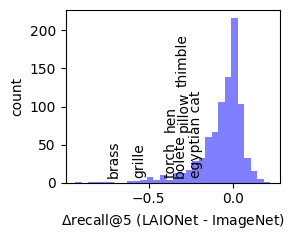

In [22]:
plt.figure(figsize=(3, 2.5))

_ = plt.hist(gaps, bins=30, color='b', alpha=0.5)

# Hardcoded
selected_wnids = ['n02892201', 'n03459775', 'n02124075', 'n03938244', 'n01514859', 'n04423845', 'n04456115', 'n13054560']
# positions = [1, 0, 1, 0, 0, 0, 0, 0]
positions = [0, 0, 0, 1, 1, 2, 0, 0]

for i_w, wnid in enumerate(selected_wnids):
    laionet_recall = topk2model2wnid2recall[k][model_name][wnid]
    ilsvrc_recall = topk2model2wnid2ilsvrcrecall[k][model_name][wnid]
    gap = laionet_recall - ilsvrc_recall
    plt.text(gap, positions[i_w]*60 + 10, query_name(wnid), rotation=90)

plt.xlabel(r'$\Delta$recall@5 (LAIONet - ImageNet)')
plt.ylabel('count')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'gap_distribtuion_{laionet_prefix}.pdf'))

# Retrieve images

In [23]:
min_gap = -0.8

max_ilsvrc_gap_wnid = wnids_filt[gaps > min_gap][0]

print(max_ilsvrc_gap_wnid)
print(wnu.get_synset(max_ilsvrc_gap_wnid))
print(query_name_def(max_ilsvrc_gap_wnid))

r1 = topk2model2wnid2recall[k][model_name][max_ilsvrc_gap_wnid]
r2 = topk2model2wnid2ilsvrcrecall[k][model_name][max_ilsvrc_gap_wnid]

print(r1, r2, r1 - r2)

n02892201
Synset('brass.n.07')
brass which is a memorial made of brass
0.21052631578947367 0.96 -0.7494736842105263


In [24]:
max_ilsvrc_gap_laionet_imgs = []
max_ilsvrc_gap_laionet_txts = []
max_ilsvrc_gap_laionindices = []

for laion_idx in tqdm(wnid2laionindices[max_ilsvrc_gap_wnid]):
    if df.loc[laion_idx, text_query_sim_col] < tq_sim_th:
        continue
    
    if df.loc[laion_idx, rec_text_is_in_col]:
        continue
    
    if laion_idx not in pred_df_concat.index:
        continue
        
    if pred_df_concat.loc[laion_idx, '0'] in drop_wnids:
        continue
        
    if len(max_ilsvrc_gap_laionet_imgs) >= 3*n_img:
        break
        
    try:
        max_ilsvrc_gap_laionet_imgs.append(download_image(df.loc[laion_idx, configs.LAIONConfig.URL_COL]))
        max_ilsvrc_gap_laionet_txts.append(df.loc[laion_idx, configs.LAIONConfig.TEXT_COL])
        max_ilsvrc_gap_laionindices.append(laion_idx)
    except Exception as e:
        print(e)

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 43/50 [00:12<00:01,  3.50it/s]


# Display

In [25]:
def add_border(img, border_width_ratio, color):
    # Create a colored border using ImageOps.expand
    img_with_border = ImageOps.expand(img, border=int(border_width_ratio*img.size[0]), fill=color)

    return img_with_border

brass which is a memorial made of brass


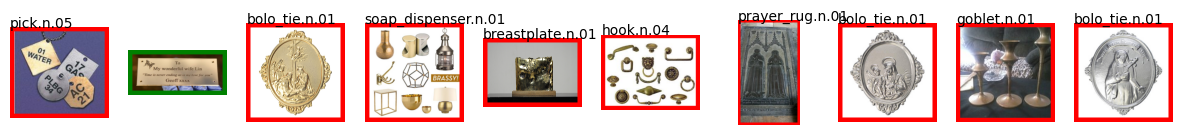

In [26]:
print(query_name_def(max_ilsvrc_gap_wnid))

if len(max_ilsvrc_gap_laionet_imgs) > n_img:
    indices = np.random.permutation(range(len(max_ilsvrc_gap_laionet_imgs)))[:n_img]
else:
    indices = range(len(max_ilsvrc_gap_laionet_imgs))
        
images = [max_ilsvrc_gap_laionet_imgs[idx] for idx in indices]
texts = [max_ilsvrc_gap_laionet_txts[idx] for idx in indices]
laion_indices = [max_ilsvrc_gap_laionindices[idx] for idx in indices]

w = 1.5
n_col = 10
n_row = n_img // n_col + 1

plt.figure(figsize=(n_col*w, n_row*w))

for i_i, image in enumerate(images):
    plt.subplot(n_row, n_col, (i_i // n_col)*n_col + i_i % n_col + 1)
    
    if (not df.loc[laion_indices[i_i], top_k_col(k, model_name)]):
        plt.imshow(add_border(image, 0.05, color='red'))
        try:
            plt.text(0, 0, wnu.get_synset(pred_df_concat.loc[laion_indices[i_i], '0']).name())
        except Exception as e:
            print(e)
    else:
        plt.imshow(add_border(image, 0.05, color='green'))
        
    plt.axis('off')
        
# plt.tight_layout()

plt.savefig(os.path.join('figs', f'max_ilsvrc_gap_{laionet_prefix}({wnu.get_synset(max_ilsvrc_gap_wnid).name()}).pdf'))

In [27]:
texts

['brass tags - Custom Metal ID Tags - Brass',
 'Engraved Brass Memorial plaque',
 'Confraternity Medal in brass, Deposition scene 3',
 'brass decor finds',
 'brass sculpture',
 'antique brass',
 'Medieval brass monument',
 'Confraternity Medal in brass, Our Lady of Mount Carmel s1',
 'assorted brass decor',
 'Confraternity Medal in brass, Our Lady of Sorrows s1']

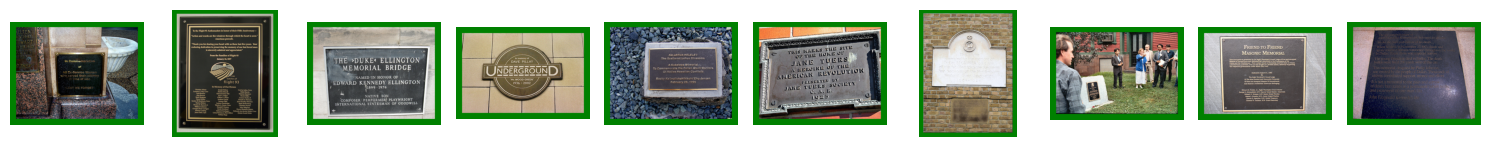

In [28]:
plt.figure(figsize=(n_col*w, n_row*w))

for i_i, img_name in enumerate(wnid2imagenames[max_ilsvrc_gap_wnid][:n_img]):
    plt.subplot(n_row, n_col, (i_i // n_col)*n_col + i_i % n_col + 1)
    
    image = Image.open(os.path.join(ilsvrc_val_img_path, img_name))
    
    if ilsvrc_val_df.loc[img_name, top_k_col(k, model_name)]:
        plt.imshow(add_border(image, 0.05, color='green'))
    else:
        plt.imshow(add_border(image, 0.05, color='red'))
        
    plt.axis('off')
            
plt.tight_layout()

plt.savefig(os.path.join('figs', f'max_ilsvrc_gap_{ilsvrc_val_prefix}({wnu.get_synset(max_ilsvrc_gap_wnid).name()}).pdf'))